In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [2]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m

In [3]:
prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/Staked_ETH_Bybit/merged_closing_prices.csv", index_col=0, parse_dates=True)

In [4]:
#get prices for dates greater than or equal to 2024-01-01 16:30:00	

#prices = prices.loc[prices.index >= "2024-01-01 16:30:00"]

# Trading simulation
---

* ## In-Sample Testing

In [5]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m


crypto_1 = prices.columns[0]
crypto_2 = prices.columns[1]

cointegrated_pairs = [(crypto_1,
  crypto_2,
  0.731393,
  0.8501886494196308,
  0.22)]

In [6]:
#Params:
window_size = 336
entry_threshold= 2.0
exit_threshold=0.1
stop_loss_threshold= 4.5

In [7]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits, price_changes_S1, price_changes_S2 = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)




Testing strategy on pair: BTC/USDT_2024_30m and WBTC/USDT_2024_30m ...
Total trades closed: 434 (Wins=429, Losses=5)
Win rate: 0.99


In [8]:
# plt.hist(zscore_series, bins=50)

In [9]:
# #Compute normalised difference between the two prices
# normalised_abs_diff = np.abs((S1 - S2) / (S1 + S2))

# #Compute the average normalised difference
# np.mean(normalised_abs_diff)

In [10]:
# #SETH and ETH Distance: 0.0003968226419110906

# s_eth_distance = 0.0003968226419110906
# w_bitcoin_distance = 0.0006442955592394416

# percentage = s_eth_distance/w_bitcoin_distance * 100
# percentage


In [11]:
# sym1

In [12]:
# price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
# price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

# len(price_changes_S2_non_zero)

In [13]:
S1

timestamp
2024-01-01 00:00:00    42419.73
2024-01-01 00:30:00    42475.23
2024-01-01 01:00:00    42493.16
2024-01-01 01:30:00    42613.56
2024-01-01 02:00:00    42546.01
                         ...   
2024-12-31 21:30:00    93899.68
2024-12-31 22:00:00    93722.23
2024-12-31 22:30:00    93488.84
2024-12-31 23:00:00    93731.05
2024-12-31 23:30:00    93576.00
Name: BTC/USDT_2024_30m, Length: 17565, dtype: float64

In [14]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost

trade_profits, cumulative_profit_series, entry_indices, exit_indices, long_spread_loss_count, short_spread_loss_count, number_of_dual_leg_profits = simulate_strategy_trade_pnl(S1, S2, positions, initial_capital, beta_series,tx_cost)

Dual Leg profit: 3.1570240200023076, 17.90611265437582
Dual Leg profit: 12.7116597711768, 5.188014108877986
Dual Leg loss: -1.1348721729174183, 24.282313702974992
Dual Leg loss: 147.00059911852452, -129.5112383185256
Dual Leg loss: 28.558710955019468, -12.977195077065442
Dual Leg profit: 0.2196245425228605, 18.86440770149445
Dual Leg profit: 14.29237581258925, 1.2009487944764148
Dual Leg loss: -1.1971354621189179, 16.262976280866717
Dual Leg loss: -8.709548439295457, 27.802596423236892
Dual Leg loss: -52.63013442008143, 66.21888855771519
Dual Leg loss: -96.59962998613321, 111.01903831057658
Dual Leg loss: 33.48251578466529, -11.577586145748114
Dual Leg loss: -6.61140707169665, 20.22977359179984
Dual Leg profit: 5.317067821178599, 13.158849554296115
Dual Leg loss: 31.64853728299029, -18.27476339132471
Dual Leg loss: -12.526102234298877, 35.56856498946377
Dual Leg loss: 54.15811825449284, -41.283682129941894
Dual Leg loss: -21.244745838279968, 34.052064369318664
Dual Leg profit: 16.28620

In [15]:
# plt.hist(trade_profits, bins=100)

In [16]:
# number_of_dual_leg_profits

In [17]:
# short_spread_loss_count

In [18]:
# #filter profits by positive values
# print(np.mean(trade_profits))

In [19]:
# #Filter for negative values

# trade_profits_neg = [x for x in trade_profits if x < 0]
# print(f"Average trade loss:  € {np.mean(trade_profits_neg)}")

# trade_profits_pos = [x for x in trade_profits if x > 0]
# print(f"Average trade win:  € {np.mean(trade_profits_pos)}")

# print("Number of negative profits(profits that were less than the transaction cost): ", len(trade_profits_neg))
# print("Number of positive profits (profits that were greater than the transaction cost): ", len(trade_profits_pos))



In [20]:
# #Calculate returns based on the trade profits
# trade_profits = np.array(trade_profits)
# returns = trade_profits/initial_capital * 100

# #Plot the returns
# plt.hist(returns, bins=50, edgecolor='black')
# plt.xlabel('Returns (%)')   
# plt.ylabel('Frequency')
# plt.title(f'Returns Distribution for Pair {sym1} and {sym2}') 

In [21]:
# #Calculate percentage price changes for each asset
# price_changes_S1 = np.array(price_changes_S1)

In [22]:
# daily_pnl_series, cum_pnl_series, cum_pnl_pct_series, shares_S1_list, shares_S2_list = simulate_strategy_pnl(S1, S2, positions_series, beta_series=beta_series, initial_capital=1_000)

# print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
# print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


In [23]:
# #Obtain non-zero price changes
# price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
# price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

# #Convert price changes to percentage
# price_changes_S1_non_zero_percent = [(x*100) for x in price_changes_S1_non_zero]
# price_changes_S2_non_zero_percent = [(x*100) for x in price_changes_S2_non_zero]

# #Print average price changes
# print(f"Average price change S1: {np.mean(price_changes_S1_non_zero_percent)} %", f"Average price change S1: {np.mean(price_changes_S2_non_zero_percent)} %")
# print(f"Number of trades: {len(price_changes_S1_non_zero)}")

In [24]:
# percentage_return = cumulative_profit_series[-1]/initial_capital * 100
# print(f"Percentage return: {percentage_return:.2f} %")


# #PROFIT SHOULD BE 0.15 EUR

# plt.figure(figsize=(10,6))
# plt.plot(cumulative_profit_series)
# plt.title('Cumulative PnL')
# plt.xlabel('Time')
# plt.ylabel('PnL (EUR)')
# plt.show()

Number of trade entries: 1
Number of trade exits: 2
Total trades: 1
Win trade: 2024-03-01 17:00:00 -> 2024-03-01 12:30:00


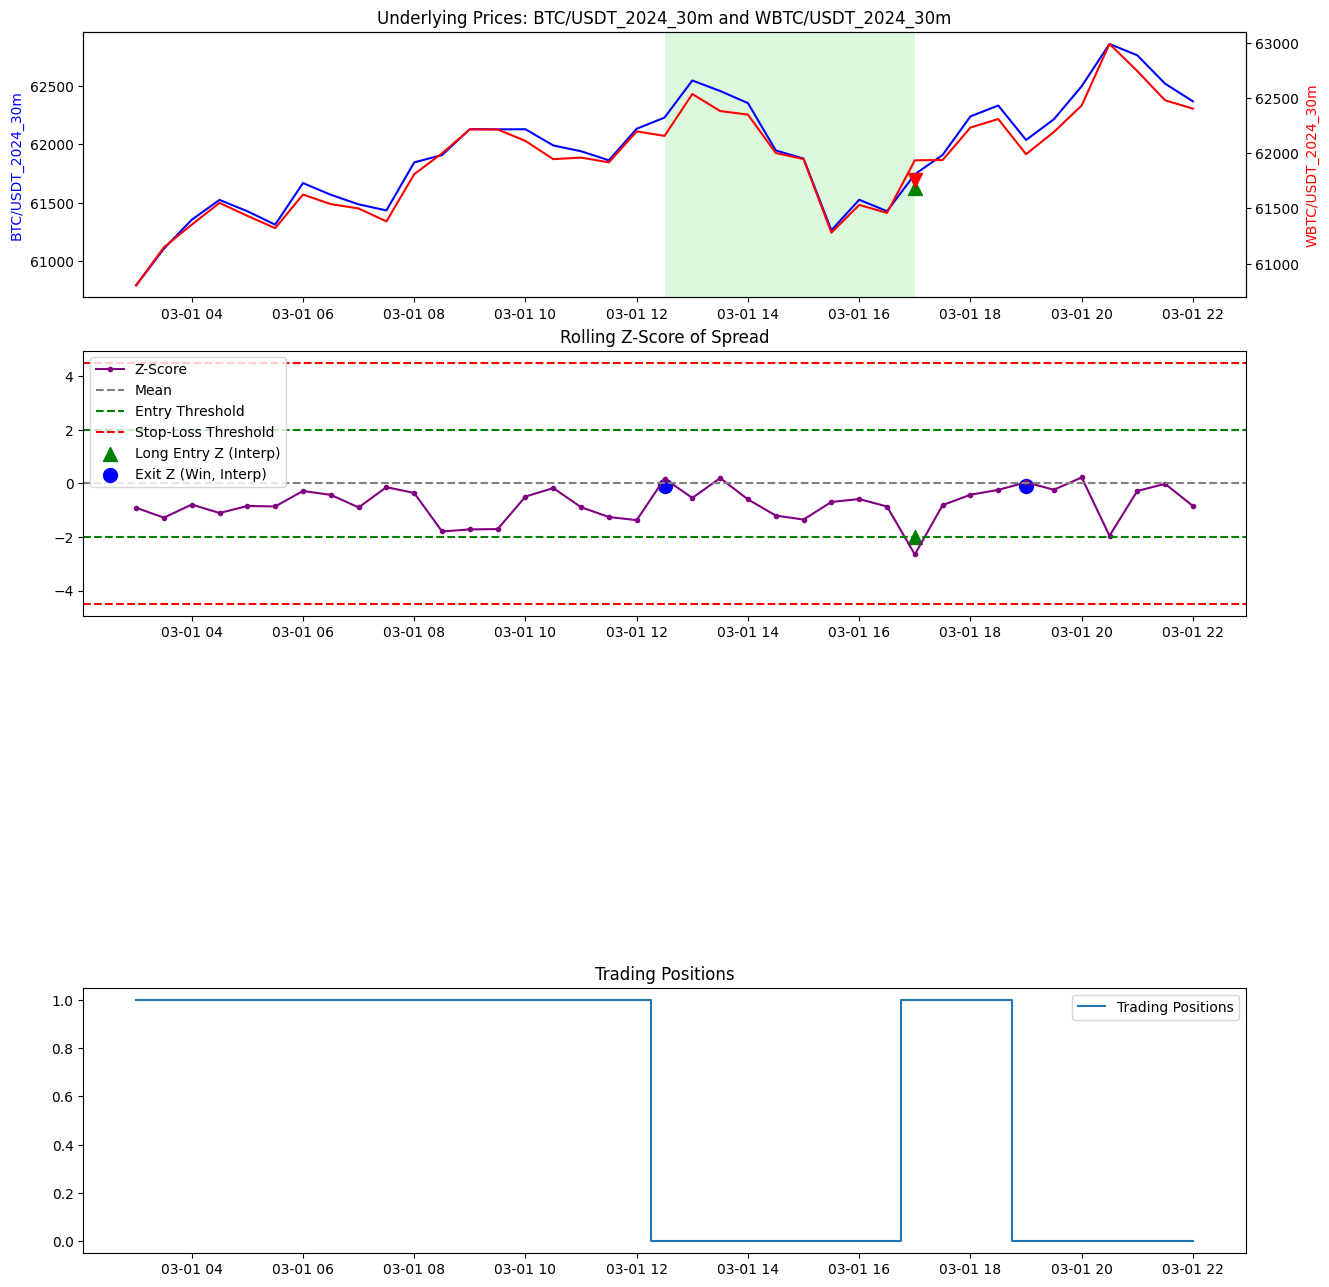

In [25]:
#Plot trading simulation
# window_start = '2023-10-03 00:00:00'
# window_end = '2023-10-03 10:00:00'


window_start = pd.to_datetime('2024-03-01 03:00:00')
window_end = pd.to_datetime('2024-03-01 22:00:00')

# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES

plot_trading_simulation(
    S1, 
    S2, 
    sym1, 
    sym2, 
    zscore_series, 
    positions, 
    entry_threshold,
    stop_loss_threshold,
    trade_entries=trade_entries,  # list of dicts: { 'time', 'S1', 'S2', 'z', 'position' }
    trade_exits=trade_exits,    # list of dicts: { 'time', 'S1', 'S2', 'z', 'exit_type' }
    window_start=window_start,
    window_end=window_end
)



In [26]:


#Get prices at the start and end of the first trade
S1_price_start = S1[entry_indices]
S2_price_start = S2[entry_indices]

S1_price_end = S1.loc[exit_indices]
S2_price_end = S2.loc[exit_indices]


#Calculate the price changes by converting the series to numpy arrays
S1_price_start = S1_price_start.to_numpy()
S2_price_start = S2_price_start.to_numpy()

S1_price_end = S1_price_end.to_numpy()
S2_price_end = S2_price_end.to_numpy()

print("BEFORE ALIGNMENT")

#Make sure the arrays have the same shape
print(S1_price_start.shape)
print(S2_price_start.shape)


print(S1_price_end.shape)
print(S2_price_end.shape)


if S1_price_start.shape > S1_price_end.shape:
    S1_price_start = S1_price_start[:len(S1_price_end)]

if S2_price_start.shape > S2_price_end.shape:
    S2_price_start = S2_price_start[:len(S2_price_end)]
 
print("AFTER ALIGNMENT")

#Make sure the arrays have the same shape
print(S1_price_start.shape)
print(S2_price_start.shape)

print(S1_price_end.shape)
print(S2_price_end.shape)

#Get the price changes
S1_price_change = S1_price_end - S1_price_start
S2_price_change = S2_price_end - S2_price_start

#Get percentage price changes
S1_price_change_percent = S1_price_change/S1_price_start * 100
S2_price_change_percent = S2_price_change/S2_price_start * 100

#Get absolute percentage price changes
S1_price_change_percent_abs = np.abs(S1_price_change_percent)
S2_price_change_percent_abs = np.abs(S2_price_change_percent)



# #Get the price changes
# S1_price_change = S1_price_end - S1_price_start
# S2_price_change = S2_price_end - S2_price_start


BEFORE ALIGNMENT
(435,)
(435,)
(434,)
(434,)
AFTER ALIGNMENT
(434,)
(434,)
(434,)
(434,)


In [27]:
#Print average S1 price change percent rounded to 2 decimal places

#Average Absolute Percentage Reversion
#---------------------------------------

print(f"Average absolute S1 price change percent: {np.mean(S1_price_change_percent_abs):.2f}%")
print(f"Average absolute S2 price change percent: {np.mean(S2_price_change_percent_abs):.2f}%")

print(f"Average of average absolute price changes: {(np.mean(S1_price_change_percent_abs) + np.mean(S2_price_change_percent_abs))/2:.2f}%")


Average absolute S1 price change percent: 0.68%
Average absolute S2 price change percent: 0.71%
Average of average absolute price changes: 0.70%
